# Uncertain Zero Sum Competition

Uncomment the following cells (by deleting the leading `#`) if you are running this in Colab.

In [ ]:
# !git clone https://github.com/wbarfuss/POLD.git

In [ ]:
# !pip install pyDOE

In [ ]:
# cd POLD

In [1]:
# imports
import os
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from environments.Env_RoleChangingZeroSum import RoleChangingZeroSum as ENV
from agents.deterministic import detQ
from utils import quiver as qv
from utils import interact as ia

# document this session for reproducibility
import IPython
print(IPython.sys_info())
print()
print('PACKAGES')
print('----- pip -----')
!pip freeze | grep -E 'numpy|scipy|pandas|matplotlib|ipython|pyDOE'
print('----- conda -----')
!conda list --export | grep -E 'numpy|scipy|pandas|matplotlib|ipython|pyDOE'

{'commit_hash': '8648ed8d7',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/Users/wolf/.miniconda3/envs/RRL/lib/python3.9/site-packages/IPython',
 'ipython_version': '7.22.0',
 'os_name': 'posix',
 'platform': 'macOS-10.16-x86_64-i386-64bit',
 'sys_executable': '/Users/wolf/.miniconda3/envs/RRL/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.9.5 (default, May 18 2021, 12:31:01) \n[Clang 10.0.0 ]'}

PACKAGES
----- pip -----
ipython @ file:///opt/concourse/worker/volumes/live/53a0fafb-1ff1-44d4-4ba9-874c42807e28/volume/ipython_1617120878135/work
ipython-genutils @ file:///tmp/build/80754af9/ipython_genutils_1606773439826/work
matplotlib @ file:///opt/concourse/worker/volumes/live/41e8cd50-031f-4dda-5787-dd3c4f4e0f08/volume/matplotlib-suite_1613407855571/work
numpy==1.22.2
pandas==1.4.1
pyDOE==0.3.8
scipy==1.8.0
----- conda -----
ipython=7.22.0=py39h01d92e1_0
ipython_genutils=0.2.0=pyhd3eb1b0_1
matplotlib=3.3.4=py39hecd8cb5_0
matplotlib-base=

In [2]:
def setup_agents(AGENTS, alpha, beta, gamma,
                 ENV, obs_noise):
    alpha, beta, gamma = map(lambda x: np.round(x,4), [alpha, beta, gamma])
    
    env = ENV(obsnoise=obs_noise)
    acts = env.actions()
    states = env.states()
    obs = env.observations()

    T = env.TransitionTensor(); assert np.allclose(T.sum(-1), 1)
    O = env.ObservationTensor(); assert np.allclose(O.sum(-1), 1)
    R = env.RewardTensor()
    F = env.FinalStates()

    agents = AGENTS(T, R, O, alpha, beta, gamma)
    
    fid = f"{ENV.__name__}_{env.noise}__"+\
        f"{AGENTS.__name__}_{alpha}_{beta}_{gamma}"
        
    infodic = dict(acts=acts, states=states, obs=obs)
    return agents, fid, infodic

def getXs(agents, n=4, radius=0.4, phi0=0):
    """
    Get policies on a circle around the mean
    """
    Xs = [agents.zeroIntelligence_behavior()]
    x0 = 0.5; y0 = 0.5
    
    for phi in np.linspace(0, 2*np.pi, n)[0:-1]:
        X = agents.zeroIntelligence_behavior()
        X[0, 0, 0] = x0 + radius*np.cos(phi+phi0); X[0, 0, 1] = 1-X[0, 0, 0] 
        X[1, 0, 0] = y0 + radius*np.sin(phi+phi0); X[1, 0, 1] = 1-X[1, 0, 0]

        if X.shape[1] == 2:        
            X[1, 1, 0] = x0 + radius*np.cos(phi); X[1, 1, 1] = 1-X[1, 1, 0] 
            X[0, 1, 0] = y0 + radius*np.sin(phi); X[0, 1, 1] = 1-X[0, 1, 0]
            
        Xs.append(X)
    return Xs

def _transform_tensor_into_hash(tens):
    """Transform tens into a string for filename saving"""
    r = int(hashlib.sha512(str(tens).encode('utf-8')).hexdigest()[:16], 16)
    return r

def compute_data(agents, NrRandomX=0, Xs=[]):
    assert NrRandomX > 0 or type(Xs) == list
    Xs = Xs + [agents.random_behavior() for _ in range(NrRandomX)]
    Xtrajs, Rtrajs = [], []
    for i in range(len(Xs)):
        X = Xs[i]
        Xtraj, Rtraj, _ = ia.compute_detXtraj(agents, X, EpsMin=1e-5,
                                              Tmax=1000)
        Xtrajs.append(Xtraj); Rtrajs.append(Rtraj)
        print(i, Rtraj[-1].round(4), Rtraj.mean(0).round(4))
    return dict(X=Xtrajs, R=Rtrajs)

def get_data(agents, agentid, NrRandomX=0, Xs=[], datfolder=None):
    assert NrRandomX > 0 or type(Xs) == list

    if NrRandomX > 0:
        fn = os.path.expanduser(datfolder) + agentid + f"__{NrRandomX}.npz"
    else:
        h = _transform_tensor_into_hash(np.array(Xs))
        fn = os.path.expanduser(datfolder) + agentid\
                + f"__Xs{h}.npz"    
    try:
        dat = np.load(fn, allow_pickle=True)
        ddic = dict(zip((k for k in dat), (dat[k] for k in dat)))
        print("Loading ", fn)
    
    except:
        print("Computing ", fn)
        ddic = compute_data(agents, NrRandomX=NrRandomX, Xs=Xs)
        if datfolder is not None:
            np.savez_compressed(fn, **ddic)
            
    return ddic

def plot_single_condition(agents, data, gisp=None, axes=None, fsf = 1.0,
                          plot=True):
    Q = agents.Q

    if gisp is not None:
        addgs = gisp.subgridspec
        fig = plt.gcf()
    elif axes is None:
        fig = plt.figure(figsize=(fsf*5, fsf*5))
        addgs = fig.add_gridspec
        
    if axes is None:
        ws=0.1; hs=1.5
        if Q == 2:
            gs = addgs(3, 2, wspace=ws, hspace=hs)
            axL = fig.add_subplot(gs[0:2, 0], ylim=(0,1), xlim=(0,1),
                                  xticks=(0,1), yticks=(0,1))
            axR = fig.add_subplot(gs[0:2, 1], ylim=(0,1), xlim=(0,1),
                                  xticks=(0,1), yticks=(0,1))
            axR.set_yticklabels([])
            
            axL.annotate(f"Obs: KeepKick", xy=(0.0, 1.0),
                         xycoords="axes fraction", color="k",
                         ha="left", va="bottom")
            axR.annotate(f"Obs: KickKeep", xy=(1.0, 1.0),
                         xycoords="axes fraction", color="k",
                         ha="right", va="bottom")
            
            axLR = [axL, axR]
        else:
            assert Q == 1
            gs = addgs(3, 4, wspace=ws, hspace=hs)
            axLR = [fig.add_subplot(gs[0:2, 1:3], xticks=(0,1), yticks=(0,1))]
            axLR[0].set_ylim(0,1); axLR[0].set_xlim(0,1)
            axLR[0].annotate(f"Obs: KK", xy=(0.5, 1.0),
                             xycoords="axes fraction", color="k",
                             ha="center", va="bottom")
        axT1 = fig.add_subplot(gs[2, :])
        
    x=([0], range(Q), [0]); y=([1], range(Q), [0])

    if plot:    
        pAs = np.linspace(0.01, 0.99, 9)
        
        qv.plot_quiver(agents, x=x, y=y, 
                       pAs=pAs, NrRandom=16, kind="quiver+samples", dens=0.4,
                       sf=0.5, policies_iter_steps=2, cmap='Greys',
                       acts=["A", "B"], conds=None, axes=axLR);

    Xtrajs = data['X']
    axes = qv.plot_trajectories(Xtrajs[0:-1], x=x, y=y, 
                        cols=['grey'],  lws=[1], mss=['.'], msss=[0],
                        lss=['-'], alphas=[0.5],
                        axes=axLR)
    axes = qv.plot_trajectories(Xtrajs[-1:], x=x, y=y, 
                        cols=['purple'],  lws=[1],  mss=['.'], msss=[0],
                        lss=['-'], alphas=[0.9],
                        axes=axLR)
    for ax in axLR:
        ax.set_title(''); ax.set_xlabel(''); ax.set_ylabel('')

    Rtrajs = data['R']
    for Rtraj in Rtrajs[0:-1]:
        axT1.plot(Rtraj[:, 0], color='darkgrey', alpha=0.5)
        axT1.plot(Rtraj[:, 1], color='lightgrey', alpha=0.5)
        
    axT1.plot(Rtrajs[-1][:, 0], color='blue', alpha=0.8)
    axT1.plot(Rtrajs[-1][:, 1], color='red', alpha=0.8)

    axT1.set_ylim(-0.05, 1.05); #axT2.set_ylim(-0.01, 1.01)
    
    axT1.set_xlabel('Time steps')
    axT1.set_yticks([0, 1])
    axT1.set_yticklabels([-1, 1])
    
    
    return axLR, axT1 #axT2

Loading  ./data/RoleChangingZeroSum_[0 0]__detQ_0.001_2000.0_0.9__Xs5635348420398806209.npz
Loading  ./data/RoleChangingZeroSum_[0.25 0.25]__detQ_0.001_2000.0_0.9__Xs5635348420398806209.npz
Loading  ./data/RoleChangingZeroSum_[0.6 0.6]__detQ_0.001_2000.0_0.9__Xs12019995672756974458.npz


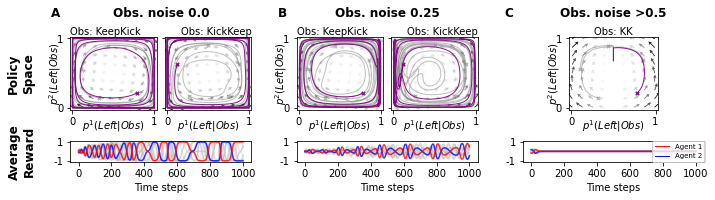

In [3]:
datfolder = "./data/"

gamma = 0.90
beta = 200 / (1-gamma)
alpha = 0.001
obsnoise = 0.25

fsf = 1.0
fig = plt.figure(figsize=(fsf*10, fsf*2.9))
gs = fig.add_gridspec(1, 3, wspace=0.25, hspace=0.35,
                      left=0.1, right=0.98, bottom=0.18, top=0.78)

plot = True

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
agents, fid, info = setup_agents(detQ, alpha, beta, gamma, ENV, obs_noise=0)
Xs = getXs(agents, n=6, radius=0.4, phi0=0.15*np.pi)[1:]     
data = get_data(agents, fid, Xs=Xs, datfolder=datfolder)
axs, axT = plot_single_condition(agents, data, gisp=gs[0], plot=plot)

axT.annotate(f"A", xy=(-0.08, 6.8), xycoords="axes fraction",
             color="k",  weight='semibold',
             ha="center", va="bottom", fontsize='large')
axT.annotate(f"Obs. noise 0.0", xy=(0.5, 6.8), xycoords="axes fraction",
             color="k",  weight='semibold',
             ha="center", va="bottom", fontsize='large')
axs[0].set_xlabel(r'$p^1(Left | Obs)$'); axs[0].set_ylabel(r'$p^2(Left | Obs)$')
axs[0].xaxis.labelpad = -9; axs[0].yaxis.labelpad = -6
axs[1].set_xlabel(r'$p^1(Left | Obs)$'); axs[1].xaxis.labelpad = -9

axs[0].annotate(f"Policy\nSpace", xy=(-0.57, 0.5), xycoords="axes fraction",
                color="k", ha="center", va="center", fontsize='large',
                weight='semibold', rotation=90)

axT.annotate(f"Average\nReward", xy=(-0.265, 0.5), xycoords="axes fraction",
                color="k", ha="center", va="center", fontsize='large',
                weight='semibold', rotation=90)



# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
noise=0.25 
agents, fid, info = setup_agents(detQ, alpha, beta, gamma, ENV, obs_noise=noise)
Xs = getXs(agents, n=6, radius=0.4, phi0=0.15*np.pi)[1:]     
data = get_data(agents, fid, Xs=Xs, datfolder=datfolder)
axs, axT = plot_single_condition(agents, data, gisp=gs[1], plot=plot)

axT.annotate(f"B", xy=(-0.08, 6.8), xycoords="axes fraction",
             color="k",  weight='semibold',
             ha="center", va="bottom", fontsize='large')
axT.annotate(f"Obs. noise {noise}", xy=(0.5, 6.8), xycoords="axes fraction",
             color="k", ha="center", va="bottom", fontsize='large', 
             weight='semibold')
axs[0].set_xlabel(r'$p^1(Left | Obs)$'); axs[0].set_ylabel(r'$p^2(Left | Obs)$')
axs[0].xaxis.labelpad = -9; axs[0].yaxis.labelpad = -6
axs[1].set_xlabel(r'$p^1(Left | Obs)$'); axs[1].xaxis.labelpad = -9



# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
agents, fid, info = setup_agents(detQ, alpha, beta, gamma, ENV, obs_noise=0.6)
Xs = getXs(agents, n=6, radius=0.4, phi0=0.15*np.pi)[1:]     
data = get_data(agents, fid, Xs=Xs, datfolder=datfolder)
axs, axT = plot_single_condition(agents, data, gisp=gs[2], plot=plot)

axT.annotate(f"C", xy=(-0.08, 6.8), xycoords="axes fraction",
             color="k",  weight='semibold',
             ha="center", va="bottom", fontsize='large')
axT.annotate(f"Obs. noise >0.5", xy=(0.5, 6.8), xycoords="axes fraction",
             color="k", ha="center", va="bottom", fontsize='large',
             weight='semibold')

axs[0].set_xlabel(r'$p^1(Left | Obs)$'); axs[0].set_ylabel(r'$p^2(Left | Obs)$')
axs[0].xaxis.labelpad = -9; axs[0].yaxis.labelpad = -6

ledli = [Line2D([0],[0], color=c, alpha=0.95, lw=1) for c in ["red", "blue"]]
ledla = [f"Agent {i}" for i in [1, 2]]
axT.legend(ledli, ledla, loc="center right", bbox_to_anchor=(1.0250, 0.5), 
            ncol=1, prop={'size': 7})


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
plt.savefig('figs/fig_ZeroSum.png', dpi=300, facecolor='w')
